# Imports

In [1]:
from pathlib import Path
from tempfile import TemporaryDirectory
import pyvista as pv
import pandas as pd
import numpy as np

from geograypher.constants import DATA_FOLDER
from geograypher.cameras.derived_cameras import COLMAPCameraSet
from geograypher.predictors.derived_segmentors import TabularRectangleSegmentor
from geograypher.utils.visualization import visualize_intersections_in_pyvista

/tmp/ipykernel_9286/3798057429.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Input data

In [2]:
COLMAP_EXAMPLE_DATA_FOLDER = Path(DATA_FOLDER, "COLMAP_bird_detection")
# These are saved from the pycolmap model
CAMERAS_FILE = Path(COLMAP_EXAMPLE_DATA_FOLDER, "cameras.txt")
IMAGES_FILE = Path(COLMAP_EXAMPLE_DATA_FOLDER, "images.txt")
POINTS_FILE = Path(COLMAP_EXAMPLE_DATA_FOLDER, "points3D.txt")
# This is saved from the df of predictions
DETECTIONS_FILE = Path(COLMAP_EXAMPLE_DATA_FOLDER, "preds.csv")
IMAGE_FOLDER = Path(COLMAP_EXAMPLE_DATA_FOLDER, "images")

# Show the COLMAP point cloud and the camera set

/ofo-share/repos-amritha/conda/envs/geograypher-amri-2/lib/python3.9/site-packages/pyvista/plotting/plotter.py:149: UserWarning: 
This system does not appear to be running an xserver.
PyVista will likely segfault when rendering.

Try starting a virtual frame buffer with xvfb, or using
  ``pyvista.start_xvfb()``

  warnings.warn(


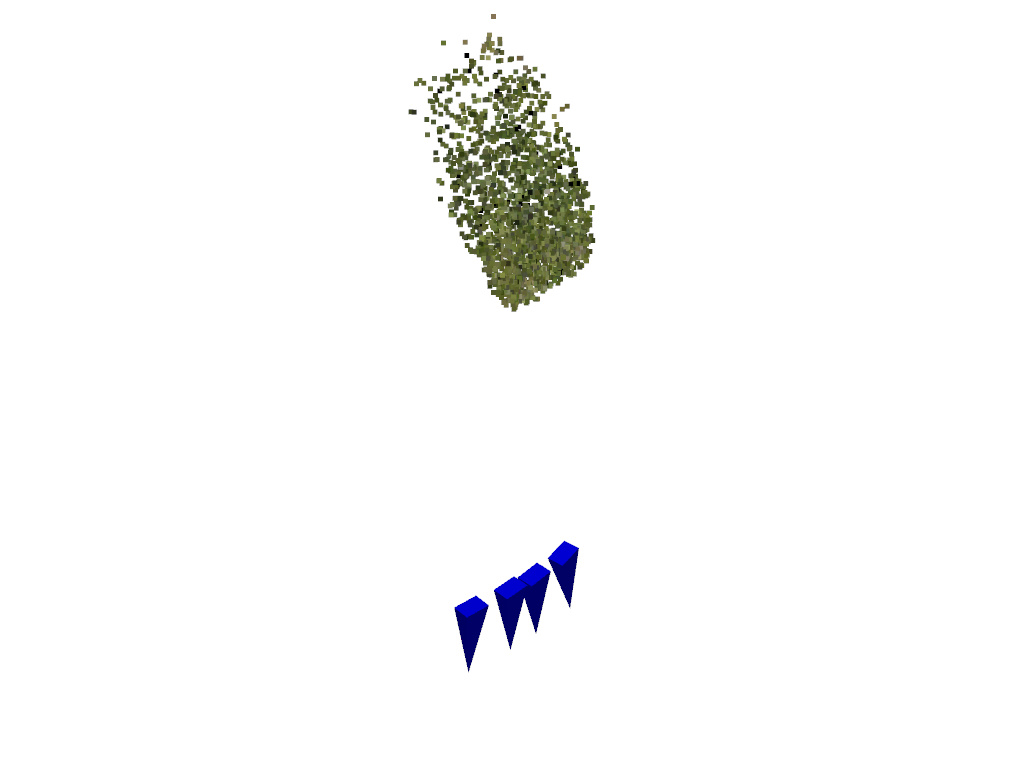

In [3]:
# Create a set of cameras from the COLMAP exports
camera_set = COLMAPCameraSet(
    cameras_file=CAMERAS_FILE,
    images_file=IMAGES_FILE,
    image_folder=IMAGE_FOLDER,
    validate_images=False,
)

# Load in the COLMAP sparse keypoints
points_df = pd.read_csv(
    POINTS_FILE,
    sep=" ",
    header=None,
    skiprows=[0, 1, 2],
    names=("POINTS3D_ID", "X", "Y", "Z", "R", "G", "B"),
    usecols=list(range(7)),
)
# Create a pyvista object from the keypoints
points_xyz = points_df[["X", "Y", "Z"]].to_numpy()
points_rgb = points_df[["R", "G", "B"]].to_numpy()
points_pv = pv.PointSet(points_xyz)

# Create a plotter to show the 3D data
plotter = pv.Plotter()
pv.start_xvfb()
# Show the keypoints
plotter.add_mesh(points_pv, scalars=points_rgb, rgb=True)
# Show the cameras
camera_set.vis(show=True, frustum_scale=10, plotter=plotter)

# Show the rays from each detection and their triangulated locations

Build community points: 100%|██████████| 23/23 [00:00<00:00, 1938.26it/s]


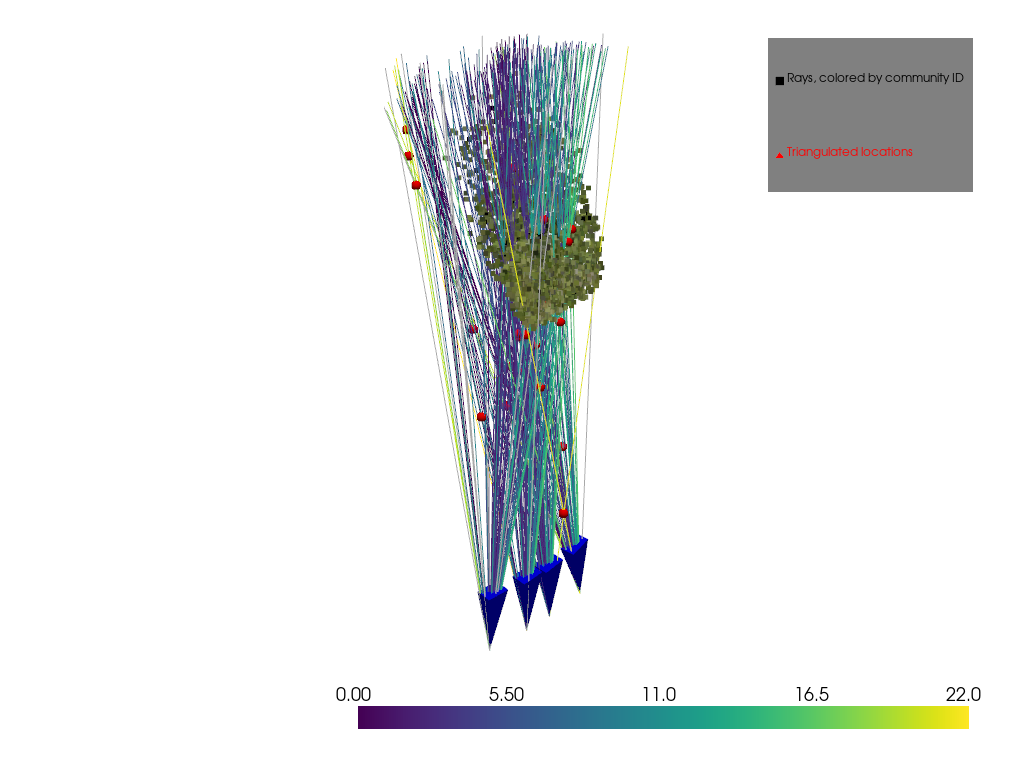

In [4]:
# This object reads the detections exported in the DeepForest format
detector = TabularRectangleSegmentor(
    detection_file_or_folder=DETECTIONS_FILE, image_folder=IMAGE_FOLDER, image_shape=(8256, 5504), split_bbox=False
)

# Create a new plotter
plotter = pv.Plotter()
# Show the mesh
plotter.add_mesh(points_pv, scalars=points_rgb, rgb=True)

with TemporaryDirectory() as tmp_dir:
    tmp_dir = Path(tmp_dir)
    # Identify correspondences between detections and show them
    camera_set.triangulate_detections(
        detector=detector, similarity_threshold_meters=0.1, ray_length_meters=80, out_dir=tmp_dir
    )

    # Also load some of the internal artifacts from triangulation
    rays = np.load(tmp_dir / "line_segments.npz")
    communities = np.load(tmp_dir / "communities.npz")

visualize_intersections_in_pyvista(
    plotter=plotter,
    ray_starts=rays["ray_starts"],
    ray_ends=rays["ray_ends"],
    community_IDs=communities["ray_IDs"],
    # Note that we are visualizing the points in the Metashape frame, not lat/lon
    community_points=communities["community_points"],
)

# Show the cameras
# TODO determine why this must be shown after the triangulation stage for proper visualization
camera_set.vis(show=True, frustum_scale=10, plotter=plotter)